In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
import copy
import torch
from torch import nn
from model import MLP
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
class Trainer:
    def __init__(self, model, criterion, optimizer, sparse_feature, device='cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.sparse_feature = sparse_feature
        self.device = device
        
    def fit(self, train_loader, test_loader=None, epoch=1, early_stop=-1, eval_type='RMSE', scaler=None):
        history = {
            'train': [], 
            'test': []
        }
        
        best_eval = 9e9
        early_cnt = 0
        best_model_params = copy.deepcopy(self.model.state_dict())
        
        for ep in tqdm(range(epoch)):
            print('Epoch:{}'.format(ep+1))
            
            for batch in train_loader:
                self.model.train()
                self.optimizer.zero_grad()
                
                x_dense, x_sparse, y = [b.to(self.device) for b in batch]
                
                output = self.model(x_dense, x_sparse, self.sparse_feature)
                loss = self.criterion(output, y)

                loss.backward()
                self.optimizer.step()
                
            train_result, _, _ = self.evaluate(train_loader, scaler)
            history['train'].append(train_result)
            print('\ttrain\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
            
            if test_loader:
                test_result, _, _ = self.evaluate(test_loader, scaler)
                history['test'].append(test_result)
                print('\ttest\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result.items()]))

                if test_result[eval_type] < best_eval:
                    early_cnt = 0
                    best_eval = test_result[eval_type]
                    best_model_params = copy.deepcopy(self.model.state_dict())
                    print('\tbetter!')

                elif early_stop > 0:
                    early_cnt += 1

            if early_cnt >= early_stop:
                break
        
        self.model.load_state_dict(best_model_params)
        
        return history
        
    def evaluate(self, loader, scaler=None):
        true_list = []
        pred_list = []
        
        self.model.eval()
        for batch in loader:
            x_dense, x_sparse, y = [b.to(self.device) for b in batch]
            output = self.model(x_dense, x_sparse, self.sparse_feature)
            
            true_list.append(y.cpu().detach().numpy())
            pred_list.append(output.cpu().detach().numpy())
        
        true_list = np.concatenate(true_list, axis=0)
        pred_list = np.concatenate(pred_list, axis=0)
        
        true_list = np.expm1(scaler.inverse_transform(true_list) if scaler else true_list)
        pred_list = np.expm1(scaler.inverse_transform(pred_list) if scaler else pred_list)
        
        result = {
            'RMSE': mean_squared_error(true_list, pred_list, squared=False), 
            'MAE(mean)': mean_absolute_error(true_list, pred_list), 
            'MAE(median)': median_absolute_error(true_list, pred_list)
        }
        
        return result, true_list, pred_list

In [4]:
sample_path = './data/sample_50k'

x_train = pd.read_csv(os.path.join(sample_path, 'Normal', 'x_train.csv'), encoding='utf-8').values
x_test = pd.read_csv(os.path.join(sample_path, 'Normal', 'x_test.csv'), encoding='utf-8').values
y_train = pd.read_csv(os.path.join(sample_path, 'Normal', 'y_train.csv'), encoding='utf-8').values
y_test = pd.read_csv(os.path.join(sample_path, 'Normal', 'y_test.csv'), encoding='utf-8').values

chid_mapper = np.load(os.path.join(sample_path, 'sample_idx_map.npy'), allow_pickle=True).item()
feat_mapper = np.load(os.path.join(sample_path, 'Normal', 'feature_map.npy'), allow_pickle=True).item()
feature = np.load(os.path.join(sample_path, 'Normal', 'feature.npy'), allow_pickle=True).item()

category_cols = feature['category_columns']
numeric_cols = feature['numeric_columns']

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, len(chid_mapper), [(k, len(v)) for k, v in feat_mapper.items()])

(450000, 31) (100000, 31) (450000, 1) (100000, 1) 50000 [('masts', 4), ('educd', 7), ('naty', 3), ('trdtp', 28), ('poscd', 10), ('cuorg', 31)]


In [5]:
sparse_feat = category_cols
dense_feat = numeric_cols

In [6]:
USE_CHID = True
idx_start = 1-int(USE_CHID)

chid_embed_dim = 64
feat_embed_dim = 4

dense_dims = len(dense_feat) # number of dense feature
feat_dims = np.array([len(chid_mapper)] + [len(v) for v in feat_mapper.values()])+1 # 0 is padding index, so add 1 dims
embed_dims = [chid_embed_dim]+[feat_embed_dim]*len(feat_mapper) # dims of chid and other sparse feature

sparse_dims = [(sf, fd, ed) for sf, fd, ed in zip(sparse_feat[idx_start:], feat_dims[idx_start:], embed_dims[idx_start:])]

print(dense_dims)
print(sparse_dims)

24
[('chid', 50001, 64), ('masts', 5, 4), ('educd', 8, 4), ('naty', 4, 4), ('trdtp', 29, 4), ('poscd', 11, 4), ('cuorg', 32, 4)]


In [7]:
# x_data
x_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_dense = x_train[:, len(sparse_feat):] # split dense feature
x_train_sparse = x_train[:, idx_start:len(sparse_feat)] # split sparse feature

x_train_dense = np.log1p(x_train_dense - x_train_dense.min(axis=0))
x_train_dense = x_scaler.fit_transform(x_train_dense)

x_test_dense = x_test[:, len(sparse_feat):]
x_test_sparse = x_test[:, idx_start:len(sparse_feat)]

x_test_dense = np.log1p(x_test_dense - x_test_dense.min(axis=0))
x_test_dense = x_scaler.transform(x_test_dense)

In [8]:
# y_data
USE_YMINMAX = False
y_scaler = None

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

if USE_YMINMAX:
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

In [9]:
print(x_train_dense.shape, x_train_sparse.shape, y_train.shape)
print(x_test_dense.shape, x_test_sparse.shape, y_test.shape)

(450000, 24) (450000, 7) (450000, 1)
(100000, 24) (100000, 7) (100000, 1)


In [10]:
batch_size = 2048

train_dataset = TensorDataset(torch.FloatTensor(x_train_dense), torch.LongTensor(x_train_sparse), 
                              torch.FloatTensor(y_train))
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)

test_dataset = TensorDataset(torch.FloatTensor(x_test_dense), torch.LongTensor(x_test_sparse), 
                             torch.FloatTensor(y_test))
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=8)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(dense_dims, sparse_dims, hidden_dims=[256, 128], out_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

MLP(
  (embedding_dict): ModuleDict(
    (chid): Embedding(50001, 64, padding_idx=0)
    (masts): Embedding(5, 4, padding_idx=0)
    (educd): Embedding(8, 4, padding_idx=0)
    (naty): Embedding(4, 4, padding_idx=0)
    (trdtp): Embedding(29, 4, padding_idx=0)
    (poscd): Embedding(11, 4, padding_idx=0)
    (cuorg): Embedding(32, 4, padding_idx=0)
  )
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=112, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
  )
  (out_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
USE_PRETRAINED = False
if USE_CHID and USE_PRETRAINED:
    embed = np.load(os.path.join(sample_path, 'embedding/node2vec_50k_0112.npy'), allow_pickle=True)
    embed = torch.from_numpy(embed[:50000])
    model.embedding_dict['chid'].weight.data.copy_(embed)

In [13]:
TRAIN_TYPE = [('RMSE', nn.MSELoss()), 
              ('MAE(mean)', nn.L1Loss())]
eval_type, criterion = TRAIN_TYPE[0]

t0 = time()
trainer = Trainer(model, criterion, optimizer, sparse_feat, device)
history = trainer.fit(train_loader, test_loader, epoch=200, early_stop=20, eval_type=eval_type, scaler=y_scaler)
t1 = time()

print('cost: {:.2f}'.format(t1 - t0))

Epoch:1
	train	RMSE:396562.03 MAE(mean):61339.64 MAE(median):11180.72
	test	RMSE:421870.59 MAE(mean):68747.68 MAE(median):11968.17
	better!
Epoch:2
	train	RMSE:393271.81 MAE(mean):58011.42 MAE(median):10530.70
	test	RMSE:417894.16 MAE(mean):64473.21 MAE(median):11090.81
	better!
Epoch:3
	train	RMSE:391272.31 MAE(mean):57033.61 MAE(median):10367.68
	test	RMSE:414993.62 MAE(mean):63390.59 MAE(median):11262.20
	better!
Epoch:4
	train	RMSE:390509.59 MAE(mean):56484.78 MAE(median):10033.64
	test	RMSE:415814.88 MAE(mean):63858.77 MAE(median):11314.78
Epoch:5
	train	RMSE:390084.19 MAE(mean):55258.61 MAE(median):9506.95
	test	RMSE:415427.28 MAE(mean):63991.19 MAE(median):11339.36
Epoch:6
	train	RMSE:385473.88 MAE(mean):53869.76 MAE(median):9559.01
	test	RMSE:412762.62 MAE(mean):66188.11 MAE(median):12610.99
	better!
Epoch:7
	train	RMSE:383970.44 MAE(mean):51294.81 MAE(median):8883.16
	test	RMSE:406112.69 MAE(mean):62156.77 MAE(median):12042.07
	better!
Epoch:8
	train	RMSE:382254.19 MAE(mean):5

In [14]:
train_result, train_true_list, train_pred_list = trainer.evaluate(train_loader, scaler=y_scaler)
test_result, test_true_list, test_pred_list = trainer.evaluate(test_loader, scaler=y_scaler)

print('train\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
print('test\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result.items()]))

train	RMSE:377154.69 MAE(mean):48846.88 MAE(median):8487.02
test	RMSE:401726.22 MAE(mean):60680.23 MAE(median):12071.53


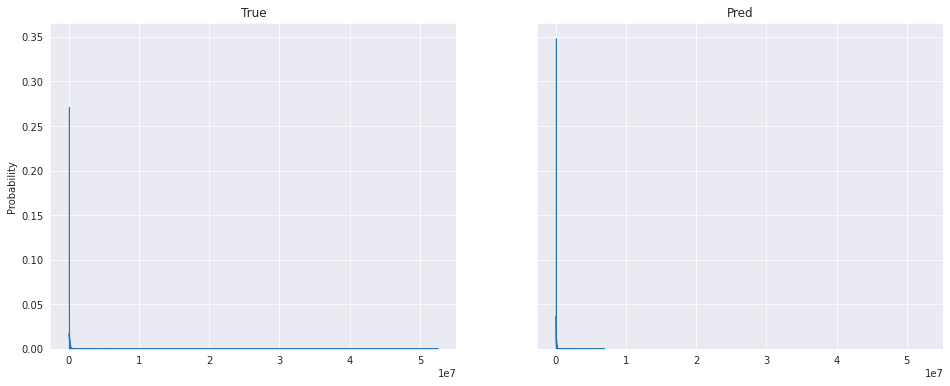

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)
    fig.suptitle('')
    
    sns.histplot(ax=axes[0], x=test_true_list.flatten(), kde=True, element='step', stat='probability')
    sns.histplot(ax=axes[1], x=test_pred_list.flatten(), kde=True, element='step', stat='probability')
    axes[0].set_title('True')
    axes[1].set_title('Pred')
    plt.show()

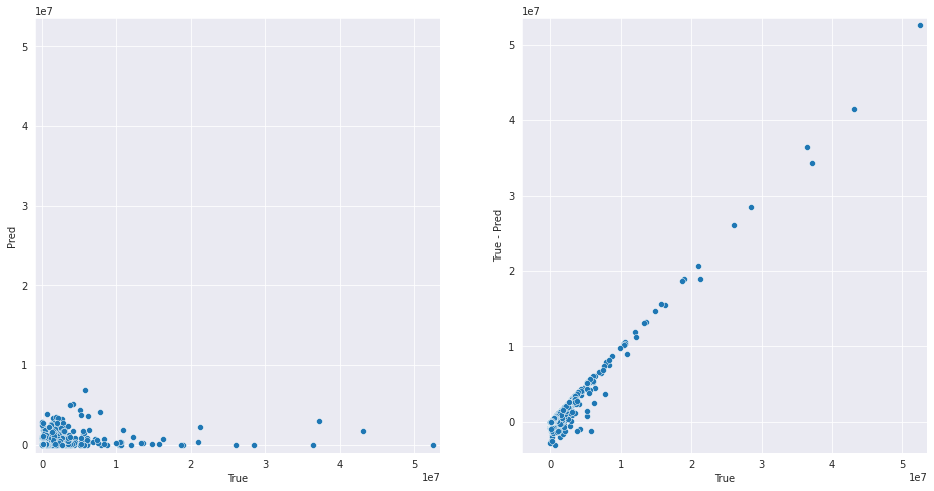

In [16]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
    fig.suptitle('')

    sns.scatterplot(ax=axes[0], x=test_true_list.flatten(), y=test_pred_list.flatten())
    xylim = (np.min([test_true_list, test_pred_list])-.1e7, np.max([test_true_list, test_pred_list])+.1e7)
    axes[0].set(xlabel='True', ylabel='Pred', xlim=xylim, ylim=xylim)
    
    sns.scatterplot(ax=axes[1], x=test_true_list.flatten(), y=test_true_list.flatten()-test_pred_list.flatten())
    xylim = (np.min([test_true_list, test_true_list-test_pred_list])-.1e7, np.max([test_true_list, test_true_list-test_pred_list])+.1e7)
    axes[1].set(xlabel='True', ylabel='True - Pred', xlim=xylim, ylim=xylim)
    plt.show()

In [17]:
df_out = pd.DataFrame({
    'chid': x_test[:, 0].astype(np.int64), 
    'true': test_true_list.flatten(),
    'pred': test_pred_list.flatten()
})

df_out.head(2)

,chid,true,pred
0,0,41007.996094,-0.939345
1,0,407783.937500,-0.937918


In [18]:
#df_out.to_csv('result/mlp_random.csv', index=False, encoding='utf-8')